In [1]:
from excellib import set_excel_color_daily
from stocklib import get_stock_price, get_OTC_price, get_otc, get_investor, get_ratio
from stocklib import cal_bar, cal_KD, check_10days, check_10days_otc, get_trust_today
from stocklib import convert_num
from stock_plot import plot_K_chart


from finance import get_yearly, get_df_monthly, get_df_monthly_check, get_df_quarterly
from finance import get_this_quarter, get_quarter_income, get_quarter_finance, set_growth_eps
from finance import get_df_quarterly_all, get_df_yearly_all

In [2]:
import requests
import shutil
import time
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import yfinance as yf
import json
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
%matplotlib inline

ua = UserAgent()
root = '../'
path_trust = root + 'trust/'
path_check = root + 'daily_check/'

## 三大法人

In [3]:
file_track = root + 'investors_track_2.xlsx'
shutil.copy2(file_track, file_track.replace('.xlsx', '_backup.xlsx')) # complete target filename given

df_track = pd.read_excel(file_track, index_col=None, engine='openpyxl')
df_track['id'] = df_track['id'].astype(str)

lst_track_tmp = list(set(df_track['id']))
lst_track = lst_track_tmp
print('追蹤股票數：', len(lst_track), lst_track)

追蹤股票數： 33 ['6116', '3051', '2439', '6698', '6191', '9910', '00633L', '8163', '9802', '3596', '2390', '00655L', '2353', '8104', '3059', '2323', '1612', '3413', '4906', '3050', '5234', '8112', '9921', '2376', '2457', '6414', '2338', '2485', '5608', '00636', '8454', '6443', '3011']


In [4]:
d_today = date.today() #- timedelta(days=1)

today_tw = d_today - relativedelta(years=1911)
this_year = d_today.year
this_quarter = get_this_quarter()
n = 1
if d_today.weekday() == 0:
    n = 3
d_yesterday = d_today - timedelta(days=n)
s_yesterday = (d_today - timedelta(days=n)).strftime("%Y%m%d")
s_today_md = (d_today).strftime("%m/%d")
s_yesterday_md = (d_today - timedelta(days=n)).strftime("%m/%d")
s_today = d_today.strftime("%Y%m%d")

s_today_tw = today_tw.strftime("%Y/%m/%d").lstrip('0')
s_thismonth_tw = today_tw.strftime("%Y/%m").lstrip('0')
print('今天:', d_today)
# 台灣證券交易所

今天: 2022-04-01


In [5]:
df_today = get_stock_price(d_today)
df_today.head(2)

取得今日上市股票資訊: 20220401


,name,amount,open,high,low,close
id,,,,,,
0050,元大台灣50,8220,136.6,136.95,136.15,136.95
0051,元大中型100,19,59.8,60.15,59.50,60.15


# 取得交易價量前30名

In [6]:
df_amt = df_today.copy()
df_amt['value_amt'] = df_amt['amount'] * df_amt['close'] # 成交量 * 收盤價(億)
df_amt['value_amt'] //= 100000
df_amt.sort_values('value_amt', ascending=False, inplace=True)
lst_amt = list(df_amt.head(30).index)
print('today:', lst_amt)

path_amt30 = './amt30.txt'
with open(path_amt30, 'r') as f:
    lst_amt30_yesterday = f.read().split('\n')
print('yesterday:', lst_amt30_yesterday)

with open(path_amt30, 'w') as f:
    for stock_id in lst_amt:
        f.write(stock_id + "\n")
lst_amt30_new = [i for i in lst_amt if i not in lst_amt30_yesterday]
print('new:', lst_amt30_new)
df_amt = df_amt.head(30)
df_amt_new = df_amt.reset_index()
df_amt_new[df_amt_new['id'].isin(lst_amt30_new)]

today: ['2330', '2454', '2603', '3035', '2609', '1708', '4919', '3037', '2303', '2618', '2610', '3532', '2888', '3189', '2344', '1732', '2368', '1314', '2317', '00637L', '2615', '2891', '2481', '2881', '1795', '4755', '2382', '2002', '2379', '2338']
yesterday: ['2330', '2454', '3035', '1708', '4919', '2603', '3037', '2481', '2609', '2610', '1513', '2618', '3532', '1795', '2303', '2615', '3017', '2883', '2317', '1732', '4755', '6415', '3661', '2409', '1609', '8046', '2345', '2891', '2351', '3189', '']
new: ['2888', '2344', '2368', '1314', '00637L', '2881', '2382', '2002', '2379', '2338']


,id,name,amount,open,high,low,close,value_amt
12,2888,新光金,278320,10.85,11.40,10.80,11.25,31.0
14,2344,華邦電,88332,30.85,30.85,29.85,30.05,26.0
16,2368,金像電,28601,84.10,91.10,84.00,88.10,25.0
17,1314,中石化,188952,12.10,13.35,12.05,13.35,25.0
19,00637L,元大滬深300正2,120615,16.36,17.34,16.31,17.18,20.0
23,2881,富邦金,21135,76.00,77.10,75.80,77.10,16.0
26,2382,廣達,17886,87.20,87.30,86.20,86.50,15.0
27,2002,中鋼,36343,38.70,39.20,38.50,39.20,14.0
28,2379,瑞昱,3563,424.00,424.00,415.00,417.00,14.0
29,2338,光罩,14931,97.50,99.50,96.30,97.00,14.0


In [7]:
df_yesterday = get_stock_price(d_yesterday)
df_yesterday.head(2)

取得今日上市股票資訊: 20220331


,name,amount,open,high,low,close
id,,,,,,
0050,元大台灣50,12975,136.60,136.6,135.50,136.1
0051,元大中型100,70,59.55,59.6,59.25,59.4


In [8]:
df_investor = get_investor(d_today)
df_investor.head(2)

外資, 投信同步買超筆數： 13044


,investor,trust,dealer_T,dealer_F
id,,,,
00637L,2884,0,0,38127
00673R,2810,0,0,16005


In [9]:
lst_investor1 = list(df_investor[  (df_investor['trust']>0)].index) # (df_investor['investor']>=0) &
lst_investor2 = list(df_investor[ (df_investor['investor']>1000) & (df_investor['trust']==0)].index)
lst_investor = set(lst_investor1 + lst_investor2)
print(len(lst_investor))
print(list(lst_investor))

141
['2542', '6116', '3044', '2890', '3443', '2345', '5434', '4770', '8215', '8081', '2884', '5880', '2498', '2449', '6770', '6477', '5388', '3037', '3653', '6531', '2353', '00673R', '2308', '9958', '9914', '6669', '1609', '8150', '6239', '2618', '3014', '2609', '2886', '2368', '2883', '2451', '2915', '2615', '2354', '6269', '6443', '2360', '2356', '8341', '3711', '6719', '3023', '4961', '6213', '3189', '2347', '5269', '1229', '1795', '2891', '9802', '3645', '2834', '3034', '1101', '3702', '8016', '4968', '2515', '2454', '00893', '4576', '2330', '2492', '2401', '1440', '2610', '6505', '2441', '3706', '1301', '2912', '2014', '1708', '2207', '8046', '1476', '2371', '6202', '3481', '2603', '00701', '2887', '3045', '2888', '9910', '6251', '00633L', '2352', '2317', '2481', '2458', '2303', '3533', '2312', '1303', '4958', '2357', '3714', '00637L', '2881', '1722', '2395', '2211', '6176', '4938', '9939', '4919', '6271', '3596', '8996', '2015', '2351', '2801', '3231', '1326', '6415', '2637', '23

In [10]:
# df_otc_trust = get_otc(d_today)
# df_otc_trust.set_index('代號', inplace=True)
# df_otc_trust['check'] = ''
# df_otc_trust.head(2)

In [11]:
# df_ratio = get_ratio(d_today) # 殖利率、本益比、股價淨值比
# df_ratio_today = df_ratio.copy()
# df_ratio_today = df_ratio_today[df_ratio_today['PER']!='-']
# df_ratio_today['PER'] = df_ratio_today['PER'].astype(float)
# # 殖利率 > 5%、本益比PER<10、股價淨值比 PBR <1
# df_ratio_today = df_ratio_today[(df_ratio_today['dividend%']>5) & (df_ratio_today['PER']<10) & (df_ratio_today['PBR']<1)]
# df_ratio_today.head(2)

In [12]:
# df_cheap_today = df_today[df_today.index.isin(df_ratio_today.index)]

# df_cheap = pd.concat([df_cheap_today, df_ratio_today], axis=1, join="inner")
# df_cheap = df_cheap[df_cheap['amount']>2000]
# df_cheap.reset_index(inplace=True)
# df_cheap['start'] = s_yesterday_md#today.strftime("%m/%d")

# file_cheap = root + 'cheap.xlsx'
# shutil.copy2(file_cheap, file_cheap.replace('.xlsx', '_backup.xlsx')) # complete target filename given
# df_cheap_old = pd.read_excel(file_cheap, index_col=None, engine='openpyxl')
# df_cheap_old['id'] = df_cheap_old['id'].astype(str)

# df_cheap_new = pd.concat([df_cheap_old, df_cheap])
# df_cheap_new.sort_values('dividend%', ascending=False)

# set_excel_color_daily(df_cheap_new, file_cheap)

In [13]:
## 今日符合篩選條件，新增至追蹤
# 漲幅 > 1.5%，K棒 > 1%
df_add = df_today.loc[lst_investor,:]
df_add.sort_index(inplace=True)

df_add['rise%'] = round((df_add['close'] - df_yesterday['close'])/df_yesterday['close']*100, 2)  # 漲跌%
df_add['K%'] = round( (df_add['close'] - df_add['open'])/df_add['open']*100, 2 )    # K棒%
df_add = df_add[ (df_add['rise%']>1.5) & (df_add['K%']>1) ]
df_add = check_10days(df_add)
lst_add_ori = list(df_add.index)
print('今日新增:',len(lst_add_ori),'筆\n', lst_add_ori)

lst_add = [i for i in df_add.index if i not in list(lst_track)] # 排除掉已經在track裡的股票
df_add = df_add.loc[lst_add,:]
df_add

00633L 交易量沒突破2倍, 沒突破次數： 9
00637L 交易量沒突破2倍, 沒突破次數： 9
1217 ,收盤價無突破10天盤整： 11.8 小於 11.8
1303 ,收盤價無突破10天盤整： 93.5 小於 93.8
1476 交易量沒突破2倍, 沒突破次數： 9
1609 ,收盤價無突破10天盤整： 29.0 小於 30.0
1708 ,前7日無盤整, 盤整天數： 3
1722 ,收盤價無突破10天盤整： 73.7 小於 80.5
2014 ,收盤價無突破10天盤整： 46.5 小於 49.2
2015 ,收盤價無突破10天盤整： 97.0 小於 99.0
2031 交易量沒突破2倍, 沒突破次數： 9
2211 ,收盤價無突破10天盤整： 62.1 小於 62.6
2308 ,收盤價無突破10天盤整： 268.5 小於 270.0
2345 ,前7日無盤整, 盤整天數： 6
2368 ,收盤價無突破10天盤整： 88.1 小於 88.5
2371 ,收盤價無突破10天盤整： 36.2 小於 37.0
2395 ,收盤價無突破10天盤整： 374.5 小於 377.5
2498 ,收盤價無突破10天盤整： 60.0 小於 62.2
2515 交易量沒突破2倍, 沒突破次數： 9
2834 ,收盤價無突破10天盤整： 12.9 小於 13.1
2880 ,收盤價無突破10天盤整： 24.4 小於 24.5
2881 交易量沒突破2倍, 沒突破次數： 9
2888 ,收盤價： 11.25 10日內最高價： 10.95
2890 ,收盤價無突破10天盤整： 18.7 小於 18.7
2891 交易量沒突破2倍, 沒突破次數： 9
2915 ,收盤價無突破10天盤整： 116.5 小於 119.5
3014 ,收盤價無突破10天盤整： 112.5 小於 116.5
3189 ,收盤價無突破10天盤整： 202.5 小於 209.0
3443 ,收盤價無突破10天盤整： 508.0 小於 536.0
3533 ,收盤價無突破10天盤整： 714.0 小於 724.0
3645 ,前7日無盤整, 盤整天數： 5
3653 ,收盤價無突破10天盤整： 419.0 小於 419.5
3661 ,前7日無盤整, 盤整天數： 6
4770 交易量沒突破2倍, 沒突破次數

,name,amount,open,high,low,close,rise%,K%,check
id,,,,,,,,,
2888,新光金,278320,10.85,11.4,10.8,11.25,6.13,3.69,9.0


In [14]:
print('量價前30名:', lst_amt)
df_amt = check_10days(df_amt)
lst_amt = list(df_amt.index)
print('量價前30名，10日盤整:',len(lst_amt),'筆', lst_amt)

量價前30名: ['2330', '2454', '2603', '3035', '2609', '1708', '4919', '3037', '2303', '2618', '2610', '3532', '2888', '3189', '2344', '1732', '2368', '1314', '2317', '00637L', '2615', '2891', '2481', '2881', '1795', '4755', '2382', '2002', '2379', '2338']
2330 ,收盤價無突破10天盤整： 589.0 小於 602.0
2454 ,前7日無盤整, 盤整天數： 3
2603 ,收盤價無突破10天盤整： 138.5 小於 145.5
3035 ,前7日無盤整, 盤整天數： 6
2609 ,收盤價無突破10天盤整： 126.5 小於 132.5
1708 ,前7日無盤整, 盤整天數： 3
4919 ,前7日無盤整, 盤整天數： 3
3037 ,收盤價無突破10天盤整： 243.5 小於 252.0
2303 ,收盤價無突破10天盤整： 52.9 小於 54.5
2618 ,收盤價無突破10天盤整： 33.0 小於 34.0
2610 ,收盤價無突破10天盤整： 27.2 小於 28.9
3532 ,前7日無盤整, 盤整天數： 4
2888 ,收盤價： 11.25 10日內最高價： 10.95
3189 ,收盤價無突破10天盤整： 202.5 小於 209.0
2344 ,前7日無盤整, 盤整天數： 6
1732 ,前7日無盤整, 盤整天數： 1
2368 ,收盤價無突破10天盤整： 88.1 小於 88.5
1314 ,收盤價： 13.35 10日內最高價： 12.4
2317 ,收盤價無突破10天盤整： 104.5 小於 108.0
00637L 交易量沒突破2倍, 沒突破次數： 9
2615 ,收盤價無突破10天盤整： 160.0 小於 167.5
2891 交易量沒突破2倍, 沒突破次數： 9
2481 ,收盤價無突破10天盤整： 100.5 小於 108.5
2881 交易量沒突破2倍, 沒突破次數： 9
1795 ,前7日無盤整, 盤整天數： 3
4755 ,收盤價無突破10天盤整： 192.5 小於 217.5
23

# 預測EPS

In [15]:
def get_EPS(lst_stock_id, filename):
    df_yearly_all = get_df_yearly_all() # 寫入歷年EPS、本益比，估算今年股價min, max範圍
    df_quarterly_all = get_df_quarterly_all()
    df_estimate = pd.DataFrame(columns = list(df_quarterly_all.columns)+['普通股數'])

    # 取得公司發行股數
    path_company_stock_num = root + 'company_list.xlsx'
    df_company_stock_num = pd.read_excel(path_company_stock_num, engine='openpyxl', dtype={'stock_id':str})
    df_company_stock_num.set_index('stock_id', inplace=True)
    
    lst_eps = []
    for i in range(len(lst_stock_id)):
        stock_id = lst_stock_id[i]
        t_wait = np.random.randint(5,15)
        print(stock_id, ', wait ', t_wait)
        df = get_df_quarterly(stock_id)

        if df is None:
            print('df is None')
            continue
        if df.loc[df.index[0], '毛利率(%)'] < 20:
            print(stock_id, '：毛利率', df.loc[df.index[0], '毛利率(%)'], '< 20%，跳過')
            continue
        elif df.loc[df.index[0], '營益率(%)'] < 8:
            print(stock_id, '：營益率' , df.loc[df.index[0], '營益率(%)'] , ' < 8%，跳過')
            continue

        lst_eps.append(stock_id)
        # 計算歷年同季的營收成長率、EPS
        df = set_growth_eps(df, df_today, stock_id)

        # 將年度EPS寫到歷年excel裡
        lst_year = set(df.index.to_series().apply(lambda x:x[:4]))
        min_year = int(min(lst_year)) # 若最小年是2018 ，只能確定2019都有資料
        lst_year = [y for y in lst_year if int(y) > min_year]
        lst_EPS = [{'year':y, 'eps': df.loc[str(y)+'Q1', 'EPS(Y)']} for y in lst_year]

        df.reset_index(inplace=True)
        df = df.rename(columns={'index':'quarter'}) # reset_index後column名稱是index

        stock_name = ""
        if stock_id in df_today.index:
            stock_name = df_today.loc[stock_id, 'name']
            df_yearly = get_yearly(stock_id, lst_EPS, df['quarter'][0][:4], stock_name)    
            df_yearly_all = df_yearly_all.append(df_yearly, ignore_index=True)

        df.insert(0, 'name', value=stock_name)
        df.insert(0, 'stock_id', value=stock_id)

        df_quarterly_all = df_quarterly_all.append(df, ignore_index=True)
        time.sleep(t_wait)

        # ===============================
        # 預測EPS ( check_EPS )
        # ===============================
        df_new_quarter = get_quarter_finance(stock_id, df, this_year, this_quarter, df_company_stock_num, df_today)
        df_concat = pd.concat([df, df_new_quarter])
        df_concat.sort_values('quarter', ascending=False, inplace=True)
        df_estimate = df_estimate.append(df_concat)

    #預測EPS ( check_EPS )
    df_estimate.to_excel(path_check+'estimate_{}_{}.xlsx'.format(filename, s_today), index=False)
    return lst_eps

In [16]:
print('今日觀察：', len(lst_add_ori), '筆')
lst_add_ori = get_EPS(lst_add_ori, 'add')
print('EPS檢查', len(lst_add_ori), '筆\n', lst_add_ori)

今日觀察： 1 筆
2888 , wait  13


c:\users\mia\appdata\local\programs\python\python37\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


2888  wait  7
EPS檢查 1 筆
 ['2888']


In [17]:
print('量價前30名：', lst_amt)
lst_amt = get_EPS(lst_amt, 'amt30')
print('EPS檢查：',len(lst_amt), '筆\n', lst_amt)

量價前30名： ['2888', '1314']
2888 , wait  5


c:\users\mia\appdata\local\programs\python\python37\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


2888  wait  9
1314 , wait  7
1314 ：毛利率 10.9 < 20%，跳過
EPS檢查： 1 筆
 ['2888']


c:\users\mia\appdata\local\programs\python\python37\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# 今日新增 && 在量價前30名

In [18]:
print('今日新增 && 在量價前30名', list(set(lst_add_ori)& set(lst_amt)) )

今日新增 && 在量價前30名 ['2888']


# 畫日K線圖、週K線圖

In [19]:
file_name = root + 'stock_20210825_1203.json'
with open(file_name) as f:
    dic_stock = json.load(f)

latest_date_file = datetime.strptime(sorted(dic_stock)[-1], '%Y-%m-%d').date()
print('目前記錄日期至:',latest_date_file, '新增前:', len(dic_stock), '筆')

目前記錄日期至: 2022-03-31 新增前: 125 筆


In [20]:
import datetime
import time
import requests
from io import StringIO
import pandas as pd
import numpy as np

def crawl_price(date):
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + str(date).split(' ')[0].replace('-','') + '&type=ALL')
    print(str(date).split(' ')[0].replace('-',''))
    ret = pd.read_csv(StringIO("\n".join([i.translate({ord(c): None for c in ' '}) 
                                        for i in r.text.split('\n') 
                                        if len(i.split('",')) == 17 and i[0] != '='])), header=0)
    ret = ret.set_index('證券代號')
    ret['成交金額'] = ret['成交金額'].str.replace(',','')
    ret['成交股數'] = ret['成交股數'].str.replace(',','')
    return ret


data_stock = {}
date_today = d_today
n_days = (d_today - latest_date_file).days
fail_count = 0
allow_continuous_fail_count = 5
print('須補天數:', n_days)
while len(data_stock) < n_days:
    print('parsing', date_today)
    # 使用 crawPrice 爬資料
    try:
        # 抓資料
        if date_today.weekday()  in [5,6]:
            print('Weekend!')
            date_today -= datetime.timedelta(days=1)
            continue
        data_stock[date_today] = crawl_price(date_today)
        if not str(date_today) in dic_stock.keys():
            dic_stock[str(date_today)] = data_stock[date_today].to_dict()
            print("add to dict:", str(date_today))
        print('success!')
        fail_count = 0
    except:
        # 假日爬不到
        print('fail! check the date is holiday')
        fail_count += 1
        if fail_count == allow_continuous_fail_count:
            raise
        break
    
    # 減一天
    date_today -= datetime.timedelta(days=1)
    time.sleep(10)

print('新增後:', len(dic_stock))
with open(file_name, 'w') as f:
    json.dump(dic_stock, f)

須補天數: 1
parsing 2022-04-01
20220401
add to dict: 2022-04-01
success!
新增後: 126


In [21]:
def plot_daily_weekly_K(lst_stock_id, dic_stock):
    df_close = pd.DataFrame({k:d['收盤價'] for k,d in dic_stock.items()}).transpose()
    df_close.index = pd.to_datetime(df_close.index)

    df_open = pd.DataFrame({k:d['開盤價'] for k,d in dic_stock.items()}).transpose()
    df_open.index = pd.to_datetime(df_open.index)

    df_high = pd.DataFrame({k:d['最高價'] for k,d in dic_stock.items()}).transpose()
    df_high.index = pd.to_datetime(df_high.index)

    df_low = pd.DataFrame({k:d['最低價'] for k,d in dic_stock.items()}).transpose()
    df_low.index = pd.to_datetime(df_low.index)

    df_volume = pd.DataFrame({k:d['成交股數'] for k,d in dic_stock.items()}).transpose()
    df_volume.index = pd.to_datetime(df_volume.index)
    
    # =========================== 畫K線圖 =================================================
    for stock_id in lst_stock_id:
        thisyear = '2021'
        print(stock_id)
        if not stock_id in df_close.keys():
            print(stock_id, '查無資料')
            continue
    #     stock_id = '2603'
        dic_a_stock = {
            'close':df_close[stock_id][thisyear].dropna().apply(lambda x:x.replace(',','')).astype(float),
            'open':df_open[stock_id][thisyear].dropna().apply(lambda x:x.replace(',','')).astype(float),
            'high':df_high[stock_id][thisyear].dropna().apply(lambda x:x.replace(',','')).astype(float),
            'low':df_low[stock_id][thisyear].dropna().apply(lambda x:x.replace(',','')).astype(float),
            'volume': df_volume[stock_id][thisyear].dropna().apply(lambda x:x.replace(',','')).astype(float),
        }

        # Daily DataFrame
        df_stock = pd.DataFrame(dic_a_stock)
        df_stock.insert(0,'stock_id', stock_id)
        df_stock.sort_index(inplace=True)

        fig_daily = plot_K_chart(df_stock, 'daily')

        # Weekly DataFrame
        period_type = '1W'
        df_week = df_stock.resample(period_type).last()
        df_week['close'] = df_stock['close'].resample(period_type).last()
        df_week['open'] = df_stock['open'].resample(period_type).first()
        df_week['high'] = df_stock['high'].resample(period_type).max()
        df_week['low'] = df_stock['low'].resample(period_type).min()
        df_week['volume'] = df_stock['volume'].resample(period_type).sum()

        fig_weekly = plot_K_chart(df_week, 'weekly')

In [22]:
print('今日新增 && 在量價前30名', list(set(lst_add_ori)& set(lst_amt)) )

今日新增 && 在量價前30名 ['2888']


今日觀察： 1 筆
2888


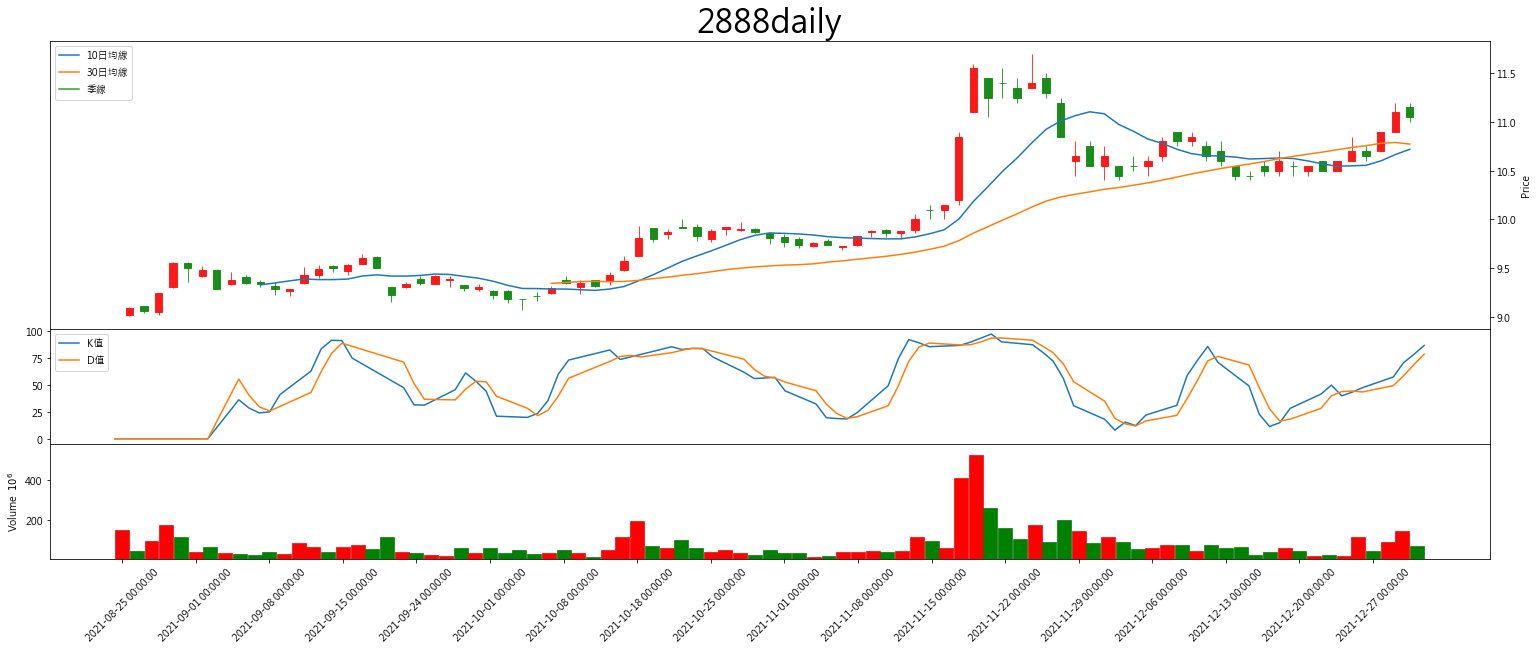

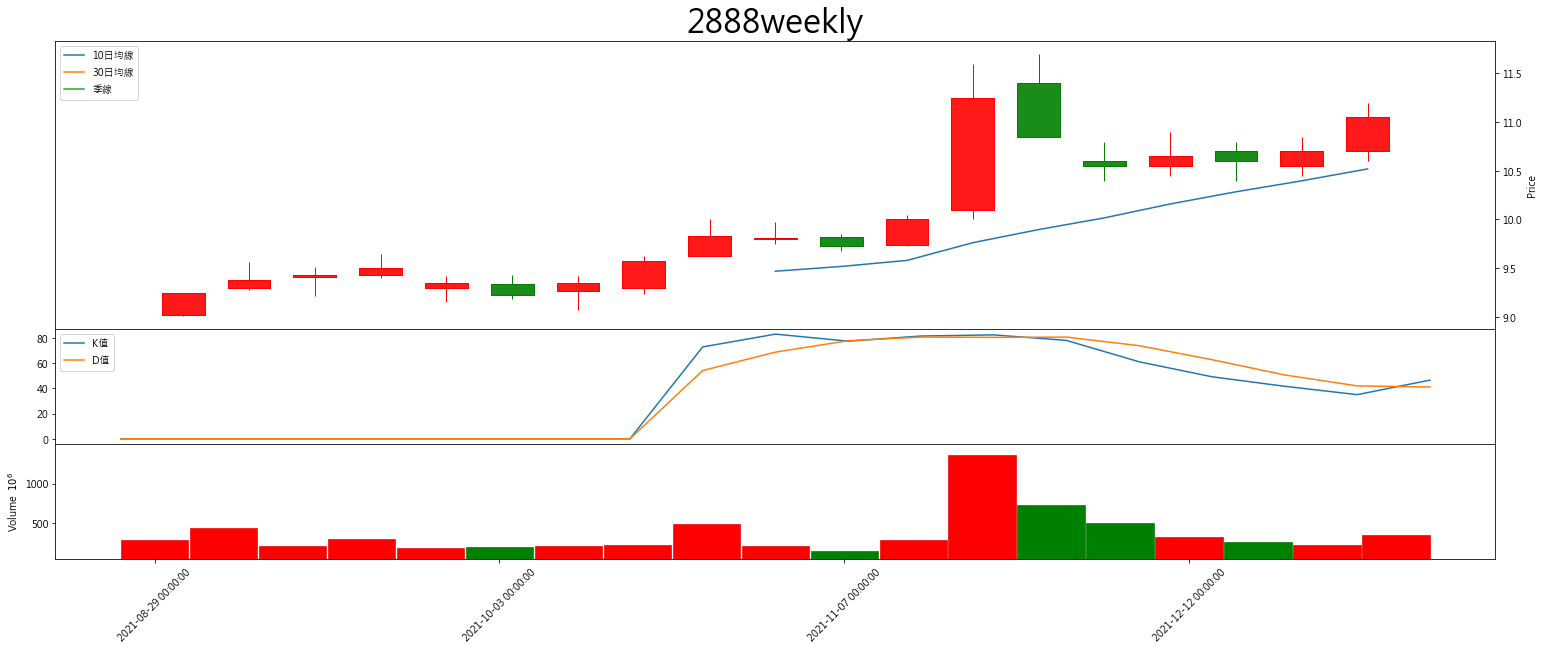

In [23]:
print('今日觀察：', len(lst_add_ori), '筆')
plot_daily_weekly_K(lst_add_ori, dic_stock)

In [24]:
print('量價前30名：', len(lst_amt),'筆\n', lst_amt)
lst_amt_without_add = [i for i in lst_amt if i not in lst_add_ori]
plot_daily_weekly_K(lst_amt_without_add, dic_stock)

量價前30名： 1 筆
 ['2888']


In [25]:
# df_yesterday = df_yesterday[df_yesterday.index.isin(df_add.index)]
# df_yesterday['rise%'] = round((df_yesterday['close'] - df_yesterday['open'])/df_yesterday['close']*100, 2) # 漲跌%
# df_yesterday['K%'] = round( (df_yesterday['close'] - df_yesterday['open'])/df_yesterday['open']*100, 2 )    # K棒%
# df_yesterday['check']=0
# df_yesterday.insert(1, 'date', s_yesterday_md)
# df_yesterday.reset_index(inplace=True)
# df_yesterday

In [26]:
# df_ori = df_today.loc[lst_track,:]
# df_ori['rise%'] = round((df_ori['close'] - df_ori['open'])/df_ori['close']*100, 2) # 漲跌%
# df_ori['K%'] = round( (df_ori['close'] - df_ori['open'])/df_ori['open']*100, 2 )    # K棒%

# df_today = pd.concat([df_ori, df_add])
# print('ori track:',lst_track, ', add：', df_add.index)
# df_today.head(2)

In [27]:
# def get_stoploss(stock_id):
#     series = df_today.loc[stock_id,:]
#     # stock_id = series['id']
#     if  series['K%'] > 6:
#         stop_point = round(series['open'] + (series['close'] - series['open'])/2, 1)
#     elif series['K%'] > 2:
#         stop_point = series['open']
#     elif stock_id in df_track['id'].unique(): # stock_id存在於原本追蹤清單中
#         stop_point = df_track[df_track['id']==stock_id]['stoploss'].iloc[0]
#     else:
#         stop_point = series['open'] # stock_id不存在於原本追蹤清單中
#     return stop_point

# def cal_mean_51018(stock_id):
#     time.sleep(0.8)
#     data_yf = yf.Ticker(stock_id+'.TW')
#     df = data_yf.history(period="1mo")
#     df.sort_index(ascending=False, inplace=True)
    
#     price_5 = round(np.mean(df['Close'][:5]),2)
#     price_10 = round(np.mean(df['Close'][:10]),2)
#     price_20 = round(np.mean(df['Close'][:20]),2)
    
#     prev_5 = round(np.mean(df['Close'][1:6]),2)
#     prev_10 = round(np.mean(df['Close'][1:11]),2)
#     prev_20 = round(np.mean(df['Close'][1:21]),2)
    
#     slope_5 = round((price_5 - prev_5)*100/price_5, 2)
#     slope_10 = round((price_10 - prev_10)*100/price_10, 2)
#     slope_20 = round((price_20 - prev_20)*100/price_20, 2) # 除上當日均價 標準化
    
#     k, d = cal_KD(stock_id, df, df_track, df_today)
#     return pd.Series([price_5, price_10, price_20, slope_5, slope_10, slope_20, k, d])

# def get_start_date(stock_id):
#     df_ori = df_track[df_track['id']==stock_id]
#     if df_ori.empty:  
#         return d_today.strftime("%m/%d")
#     else:
#         return df_ori['start'].iloc[0]

In [28]:
# # 停損點、上影線、下影線
# df_today.insert(1, 'date', s_today_md)
# df_today['stoploss'] = df_today.index.to_series().apply(get_stoploss)
# df_today[ ['up_bar', 'low_bar'] ] = df_today.apply(lambda x: cal_bar(x.open, x.high, x.low, x.close), axis=1)

# # 5, 10 ,20日均線，K,D值
# df_today[ ['close5', 'close10', 'close20', 'slope5','slope10', 'slope20', 'Kvalue', 'Dvalue'] ]  = \
#         df_today.index.to_series().apply(cal_mean_51018) # 太長了

# df_today.head(2)

In [29]:
# df = pd.concat([df_today, df_investor, df_ratio], axis=1, join="inner")
# df.reset_index(inplace=True)

# df_all = pd.concat([df, df_yesterday])

# df_all['start'] = df_all['id'].apply(get_start_date)
# df_all.head(2)

In [30]:
# df_new = pd.concat([df_track, df_all])
# df_new.sort_values(['id', 'date'], ascending=[True, False], inplace=True)
# df_new.head()

In [31]:
# set_excel_color_daily(df_new, file_track)

In [32]:
# # 目前持有股票
# file_asset = root + 'asset.xlsx'
# shutil.copy2(file_asset, file_asset.replace('.xlsx', '_backup.xlsx')) # complete target filename given

# txt = root + 'asset.txt'
# with open(txt, 'r', encoding='utf8') as f:
#     dic = json.loads(f.read())
# lst_asset = list(dic.keys())
# print(lst_asset)

# df_asset = df_new[df_new['id'].isin(lst_asset)]
# set_excel_color_daily(df_asset, file_asset)
# df_asset

# 投信買超

In [33]:
# # 投信買超 上櫃公司
# df_otc_add = df_otc_trust.copy()
# df_otc_add = check_10days_otc(df_otc_add)
# df_otc_add.insert(0, 'date', s_today_md)
# df_otc_add.reset_index(inplace=True)

# path_otc = path_trust + 'otc.xlsx'
# shutil.copy2(path_otc, path_otc.replace('.xlsx', '_backup.xlsx'))
# df_otc_add.to_excel(path_otc, index=False)
# df_otc_add

In [34]:
# # 當日投信買超 上市、上櫃公司
# url_trust = 'https://www.twse.com.tw/fund/TWT44U?response=html&date={}'.format(s_today)
# tables = pd.read_html(url_trust)
# df_trust = tables[0]
# df_trust = df_trust.iloc[:,[1,5]]
# df_trust.columns = ['stock_id', '買賣超']
# df_trust = df_trust.astype({'stock_id':str, '買賣超':int})
# df_trust.iloc[:,-1] = df_trust.iloc[:,-1].apply(lambda x: round(x/1000,0))
# df_trust = df_trust[df_trust['買賣超']>20]
# df_trust.set_index('stock_id', inplace=True)
# df_trust.head(2)

In [35]:
# # 投信持股比例
# path_trust = 'D:/Mia/Stock/trust/'
# path_html = path_trust + 'StockList.html'
# tables = pd.read_html(path_html)
# df_trust_today = tables[0]
# df_trust_today.columns = df_trust_today.iloc[0,:]
# df_trust_today = df_trust_today.iloc[1:,:]
# df_trust_today.dropna(inplace=True)
# df_trust_today['今年買賣超佔發行張數'] = df_trust_today['今年買賣超佔發行張數'].apply(convert_num)
# df_trust_today['一個月買賣超佔發行張數'] = df_trust_today['一個月買賣超佔發行張數'].apply(convert_num)
# df_trust_today['三個月買賣超佔發行張數'] = df_trust_today['三個月買賣超佔發行張數'].apply(convert_num)
# df_trust_today = df_trust_today[(df_trust_today['今年買賣超佔發行張數']>2) & \
#                                 (df_trust_today['三個月買賣超佔發行張數']>0) & (df_trust_today['一個月買賣超佔發行張數']>0)]
# lst_trust_today = [str(i) for i in list(df_trust_today['代號'])]
# print(lst_trust_today)

# # 存檔
# path_trust_list = path_trust + 'trust.xlsx'
# shutil.copy2(path_trust_list, path_trust_list.replace('.xlsx', '_backup.xlsx'))

# df_trust_list = pd.read_excel(path_trust_list, engine='openpyxl')
# print('old：', df_trust_list.shape)
# print('new：', df_trust_today.shape)
# df_trust_new = pd.concat([df_trust_list,df_trust_today]).drop_duplicates().reset_index(drop=True)
# print('concat：', df_trust_new.shape)
# df_trust_new.sort_values(['代號', '更新日期'], ascending=[True, False])
# df_trust_new.to_excel(path_trust_list, index=False)
# df_trust_new.head(1)

In [36]:
# lst_trust_add = [i for i in lst_trust_today if i in df_today.index]
# print('投信買超：', len(lst_trust_today), lst_trust_today)
# print('上市公司：', len(lst_trust_add), lst_trust_add)

# df_trusk_add = df_today.loc[lst_trust_add,:]
# df_trusk_add.sort_index(inplace=True)

# # df_trusk_add['rise%'] = round((df_trusk_add['close'] - df_yesterday['close'])/df_yesterday['close']*100, 2)  # 漲跌%
# df_trusk_add['K%'] = round( (df_trusk_add['close'] - df_trusk_add['open'])/df_trusk_add['open']*100, 2 )    # K棒%
# df_trusk_add = df_trusk_add[df_trusk_add['K%']>1] # df_trusk_add['rise%']>1.5) & 
# df_trusk_add = check_10days(df_trusk_add)
# df_trusk_add

In [37]:
# df_fund = pd.read_excel(root + 'trust/fund_list.xlsx', engine='openpyxl')
# lst_fund = list(df_fund['基金編號'])
# print(lst_fund)

# path_fund_holding = path_trust+'holding.xlsx'
# shutil.copy2(path_fund_holding, path_fund_holding.replace('.xlsx', '_backup.xlsx'))
# df_holding_ori = pd.read_excel(path_trust+'fund_holding.xlsx', engine='openpyxl')
# for fund_id in lst_fund:
# #     fund_id = 'AC0053'
#     url = 'https://finet.landbank.com.tw/w/wr/wr04.djhtm?a={}'.format(fund_id)
#     tables = pd.read_html(url)
#     df_holding = tables[1]

#     col_idx = df_holding[df_holding[0]=='股票名稱'].index[0] # 取得col name index
#     df_holding.columns = df_holding.iloc[col_idx,:]
#     df_holding = df_holding.iloc[col_idx+1:-1,:]

#     df_1 = df_holding.iloc[:,:4]
#     df_2 = df_holding.iloc[:, 4:]
#     df_holding = pd.concat([df_1, df_2], ignore_index=True)
#     df_holding.dropna(inplace=True)
#     df_holding['增減'] = df_holding['增減'].apply(lambda x : x.replace('%', ''))
#     df_holding = df_holding.astype({'比例':float, '增減':float})
# #     df_holding = df_holding[df_holding['增減']>0.08]
#     df_holding.insert(0, 'date', s_today_md)
#     df_holding.insert(0, 'stock_id', fund_id)
#     df_holding_ori = df_holding_ori.append(df_holding)
#     time.sleep(0.3)

# # df_holding_new = pd.concat([df_holding_ori,df_holding])
# df_holding_ori.to_excel(path_trust+'fund_holding.xlsx', index=False)


In [38]:
# for idx, row in df_holding_ori.iterrows():
#     df_holding_ori.at[idx, 'count'] = df_count.loc[row['股票名稱'], 'count']
# df_holding_ori.to_excel(path_trust+'fund_holding.xlsx', index=False)
# df_holding_ori.head(2)

In [39]:

# df_trust_5days = pd.read_excel(path_trust + 'trust_5days.xlsx', engine='openpyxl')
# df_trust_5days = df_trust_5days[df_trust_5days['今年買賣超佔發行張數']>2]
# df_trust_5days = df_trust_5days[df_trust_5days['三個月買賣超佔發行張數']>0]
# df_trust_5days = df_trust_5days[df_trust_5days['一個月買賣超佔發行張數']>0]

# df_fund_holding = pd.read_excel(path_trust + 'fund_holding.xlsx', engine='openpyxl')
# lst_fund_holding = list(df_fund_holding['股票名稱'].unique())
# print(lst_fund_holding[:5])

# df_trust_5days = df_trust_5days[df_trust_5days['名稱'].isin(lst_fund_holding)]
# df_trust_5days = df_trust_5days.iloc[:,1:]
# df_trust_5days.to_excel(path_trust + 'trust_check.xlsx', index=False)
# print(list(df_trust_5days['代號']))
# df_trust_5days

# 盤中檢查

In [40]:
# # c: 代號
# # o: 開盤價
# # z: 當盤成交價，有時候會沒有
# # v: 成交量
# # y: 昨日收盤
# import requests
# url = "https://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_2330.tw|tse_3008.tw"
# res = requests.get(url)
# res.json()['msgArray']

# df = pd.DataFrame(res.json()['msgArray'])
# df = df[['c','o', 'z', 'v', 'y']]
# df.columns = ['stock_id', 'open', 'price', 'volume', 'yesterday']
# df[df.columns[1:]] = df[df.columns[1:]].astype(float)
# # df = df[df['price']>df['yesterday']] # 今天漲
# df['rise%'] = round((df['price'] - df['yesterday'])/df['yesterday']*100, 2)
# df = df[df['rise%']>2] # 漲幅>2%
# df

In [41]:
# data = yf.Ticker('2603'+'.TW')
# df_hist = data.history(period="1mo")
# df_hist.sort_index(ascending=False, inplace=True)
# df_hist.head(2)

In [42]:
# import io
# io_buf = io.BytesIO()
# a.savefig(io_buf, format='raw')
# io_buf.seek(0)
# img_a = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
#                      newshape=(int(a.bbox.bounds[3]), int(a.bbox.bounds[2]), -1))

# b.savefig(io_buf, format='raw')
# io_buf.seek(0)
# img_b = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
#                      newshape=(int(b.bbox.bounds[3]), int(b.bbox.bounds[2]), -1))
# io_buf.close()

In [43]:
# # img_a = np.fromstring(a.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# # print(a.canvas.get_width_height()[0] * a.canvas.get_width_height()[-1] * 3)
# # print(img_a.shape)
# # img_a = img_a.reshape(a.canvas.get_width_height()[::-1] + (3,))

# figures = {'a':img_a, 'b':img_b}
# nrows, ncols = 2, 1
# fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
# for ind,title in enumerate(figures):
#     print(ind, title)
#     axeslist.ravel()[ind].imshow(figures[title])
# #     axeslist.ravel()[ind].set_title(title)
# #     axeslist.ravel()[ind].set_axis_off()
# plt.tight_layout() # optional
# # ValueError: cannot reshape array of size 3378075 into shape (576,1728,3)

In [44]:
# df_week = pd.DataFrame(columns=df_stock.columns)
# df_week

In [45]:
# from talib import abstract

# def talib2df(talib_output):
#     if type(talib_output) == list:
#         ret = pd.DataFrame(talib_output).transpose()
#     else:
#         ret = pd.Series(talib_output)
#     ret.index = tsmc['close'].index
#     return ret;

# talib2df(abstract.STOCH(tsmc)).plot()
# tsmc['close'].plot(secondary_y=True)

In [46]:
# import matplotlib.pyplot as plt
# import mplfinance as mpf
# %matplotlib inline
# import seaborn as sns

# # mplfinance內建的漲/跌標記顏色是美國的版本(綠漲紅跌)，先用mplfinance中自訂圖表外觀功能mpf.make_marketcolors()將漲/跌顏色改為台灣版本(紅漲綠跌)，
# # 接著再將這個設定以mpf.make_mpf_style()功能保存為自訂的外觀。
# mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
# s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# # df_stock.index = df_stock.index.format(formatter=lambda x: x.strftime('%Y-%m-%d')) 
# df_stock.index.name = 'Date'
# fig = plt.figure(figsize=(24, 8))

# # add_axes( x初始座標, y初始座標, 寬, 高 )
# ax1 = fig.add_axes([0, 0.3, 1, 0.5])
# ax2 = fig.add_axes([0, 0, 1, 0.3])
# # ax1 = fig.add_subplot(1, 1, 1)
# # ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
# ax2.set_xticks(range(0, len(df_stock.index), 5))
# ax2.set_xticklabels(df_stock.index[::5])
# # mpf.candlestick2_ochl(ax, df_stock['open'], df_stock['close'], df_stock['high'],
# #                       df_stock['low'], width=0.6, colorup='r', colordown='g', alpha=0.75); 

# mpf.plot(df_stock, type = 'candle', mav=(10,30), ax=ax1, style=s, volume=ax2) # 必須指定volume一個軸



# 月報

#### 彙總報表 (單位：千元)
https://mops.twse.com.tw/mops/web/t21sc04_ifrs